In [40]:
%config InlineBackend.figure_formats = ['retina']
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

# Load data

In [41]:
names = ['Ant', 'Grapes']

In [42]:
X_ant = np.load('./data/G_21_ant.npy')
X_grapes = np.load('./data/G_21_grapes.npy')

In [43]:
X_test = np.load('./data/test_images.npy')
y_test = np.load('./data/test_labels.npy').astype(int)

# Creates labels for ant and grapes

The labels defined in the test set are ant = label $0$ and grapes = label $1$, so we will use the same labelling for the train set.

In [44]:
y_ant = np.zeros((X_ant.shape[0],))
y_grapes = np.ones((X_grapes.shape[0],))

# Merge the data into one matrix

In [45]:
X_train = np.concatenate((X_ant, X_grapes), axis=0)

In [46]:
y_train = np.concatenate((y_ant, y_grapes), axis=0).astype(int)

We want to shuffle the data to be sure that the data set is representative of both classes.

In [47]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

Standardisation of the data is necessary for the PCA. We use the same transformation on X_train and on X_test.

In [48]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# PCA for dimensionality reduction

We want to keep the first two principal components of the PCA in order to be able to represent the data in 2D, which may give us clues about rather the data is linearly separable or not.

In [49]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

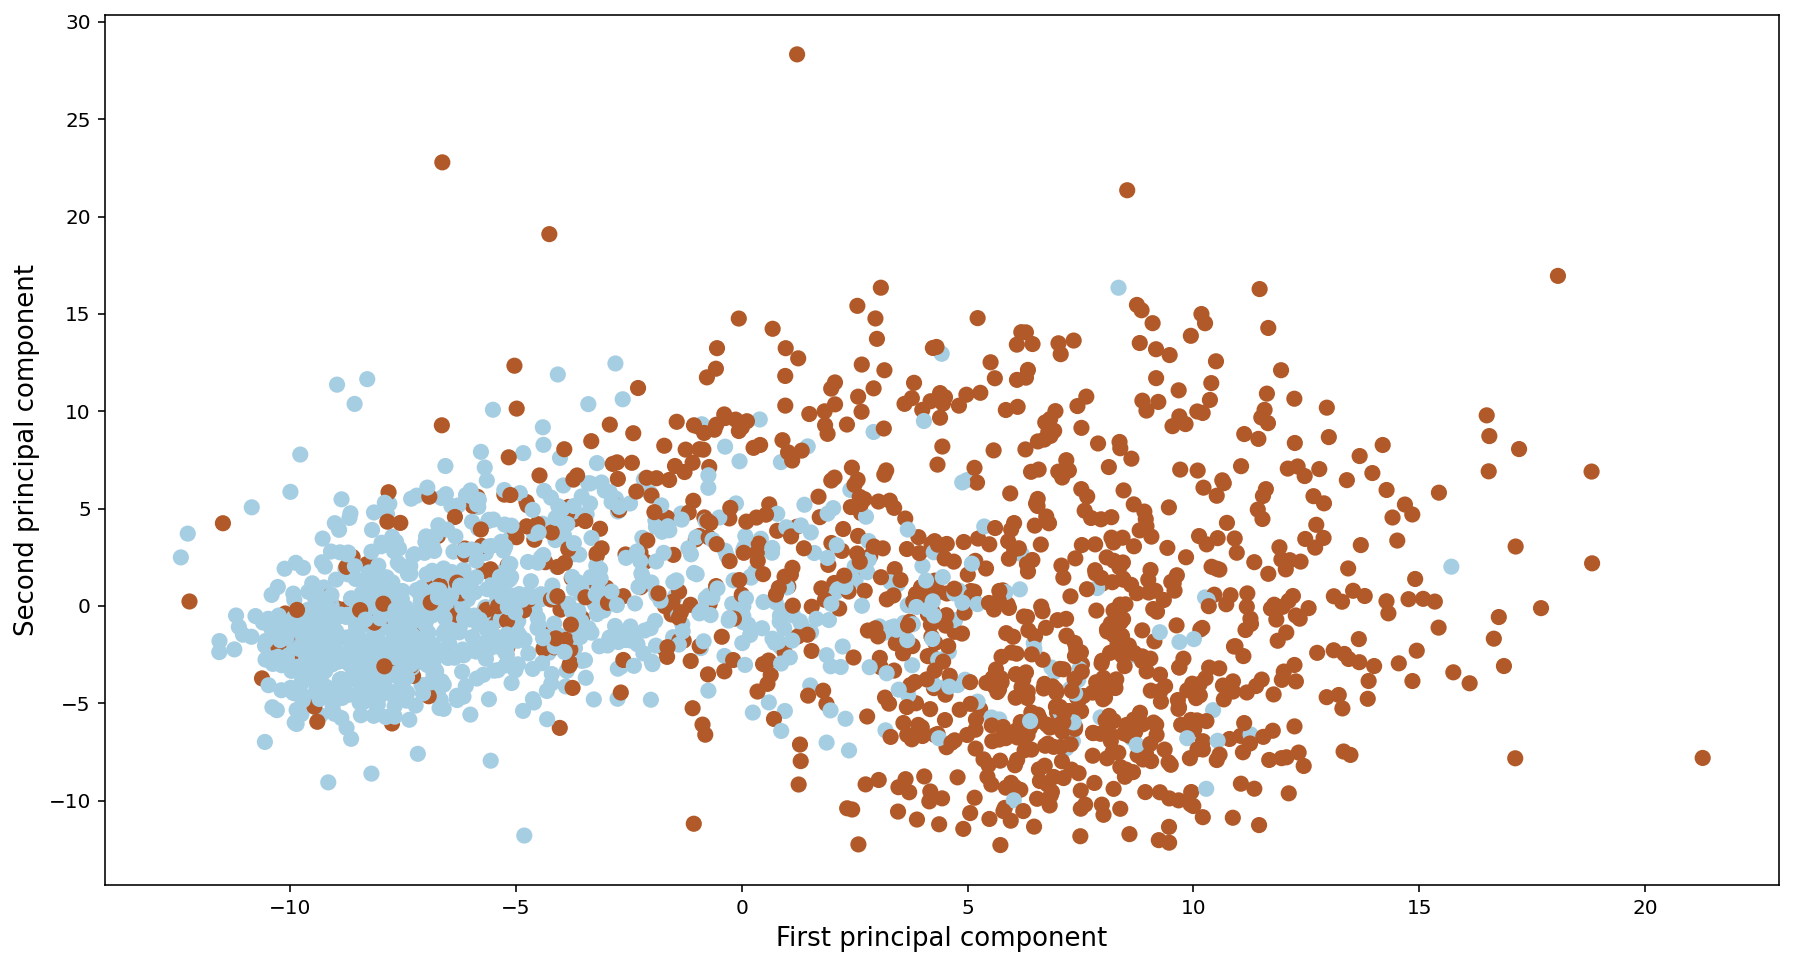

In [50]:
plt.figure(figsize=(15,8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=50, cmap=plt.cm.Paired)
plt.xlabel('First principal component', size=13)
plt.ylabel('Second principal component', size=13)
plt.show()

From the plot, we can see that the data is not linearly separable at all. We will therefore only use non-linear classifiers.

First, we will start by using SVM with a Gaussian kernel.

# SVM with a Gaussian kernel

We use cross-validation to determine the best values for the hyperparameters.

In [51]:
%%time
clf_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid={'C':np.linspace(1,1,10), 'gamma':['scale', 'auto']})
clf_rbf.fit(X_train, y_train)
print(clf_rbf.best_params_)

{'C': 1.0, 'gamma': 'scale'}
CPU times: user 1min 57s, sys: 1.74 s, total: 1min 58s
Wall time: 2min 5s


In [52]:
print('Accuracy on train set:', clf_rbf.score(X_train, y_train))
print('Accuracy on test set:', clf_rbf.score(X_test, y_test))

Accuracy on train set: 0.956
Accuracy on test set: 0.86


This first model gives quite good results on the test set, but it can potentially be increased by using a different classification model. However, the score the train set is almost 1, which means that there is overfitting in our model.

Therefore, we will use decision tree (and Random Forest) to try to obtain results as good as those obtained with SVM, but with less overfitting so that the model might perform better on new data.

# Decision Tree

We try first with a Decision Tree and use cross-validation to determine the best hyperparameters (and especially the ``max_depth`` to avoid overfitting).

In [53]:
%%time
d_tree_params = {'criterion' : ['gini', 'entropy'], 'splitter' : ['best', 'random'], 'max_depth' : np.arange(1,6)}
dec_tree = GridSearchCV(DecisionTreeClassifier(),d_tree_params)
dec_tree.fit(X_train,y_train)
print(dec_tree.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}
CPU times: user 8.53 s, sys: 119 ms, total: 8.65 s
Wall time: 8.75 s


In [54]:
print('Accuracy on train set:', dec_tree.score(X_train, y_train))
print('Accuracy on test set:', dec_tree.score(X_test, y_test))

Accuracy on train set: 0.868
Accuracy on test set: 0.764


By reducing the ``max_depth`` paramater, we were able to reduce the time to find the best parameters and the training time. Therefore, the model is much faster than the SVM but we obtain poorer results. We might be able to improve them by using a Random Forest Classifier.

# Random Forest Classifier

In [55]:
%%time
rf_params = {'criterion' : ['gini', 'entropy'], 'max_depth' : np.arange(2,6)}
rfc = GridSearchCV(RandomForestClassifier(),rf_params)
rfc.fit(X_train,y_train)
print(rfc_cv.best_params_)

{'criterion': 'entropy', 'max_depth': 5}
CPU times: user 27 s, sys: 429 ms, total: 27.4 s
Wall time: 29.6 s


In [56]:
print('Accuracy on train set:', rfc.score(X_train, y_train))
print('Accuracy on test set:', rfc.score(X_test, y_test))

Accuracy on train set: 0.897
Accuracy on test set: 0.838


Using Random Forest gives us significantly better results than with the Decision tree. It is a bit longer to determine the hyperparameters and to train the model. In addition, we have limited to 5 the maximum depth because increasing it more than that was increasing the train accuracy, but very little the test accuracy.

Thus, we obtain results that are nearly as good as the results obtained with SVM, but the computation time is much lower and there is less overfitting.

Finally, we want to train a neural network to determine whether we can get better results without too much overfitting.

# Neural network

For the architecture of the neural network, we have 784 values in input and only 2 values in output. We use the sigmoid activation function for the output layer because we want a value between 0 and 1, that will represent the probability of being either of class 0 or of class 1.

Then, we have tested different architecture (with more hidden layers, with different number of neurons per layer), and we have found that the following architecture gives us the best results on average.

In [57]:
y_train_NN = to_categorical(y_train)
y_test_NN = to_categorical(y_test)

In [58]:
model = Sequential()
input_shape = 784
layer_1_shape = 300
output_shape = 2
model.add(Dense(layer_1_shape, activation='relu', input_dim=input_shape))
model.add(Dense(output_shape, activation='sigmoid'))

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
%%time
epochs=10
history = model.fit(X_train, y_train_NN, epochs=epochs, batch_size=10, validation_data=(X_test, y_test_NN))

Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5491 - accuracy: 0.8116 - val_loss: 0.4409 - val_accuracy: 0.8380
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1705 - accuracy: 0.9419 - val_loss: 0.3962 - val_accuracy: 0.8610
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0986 - accuracy: 0.9686 - val_loss: 0.5015 - val_accuracy: 0.8460
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0495 - accuracy: 0.9869 - val_loss: 0.5229 - val_accuracy: 0.8630
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0298 - accuracy: 0.9902 - val_loss: 0.5243 - val_accuracy: 0.8580
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0181 - accuracy: 0.9975 - val_loss: 0.5971 - val_accuracy: 0.8530
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0116 - accuracy: 0.9968 - val_loss: 0.7907 - val_accuracy: 0.8530
Epoch 

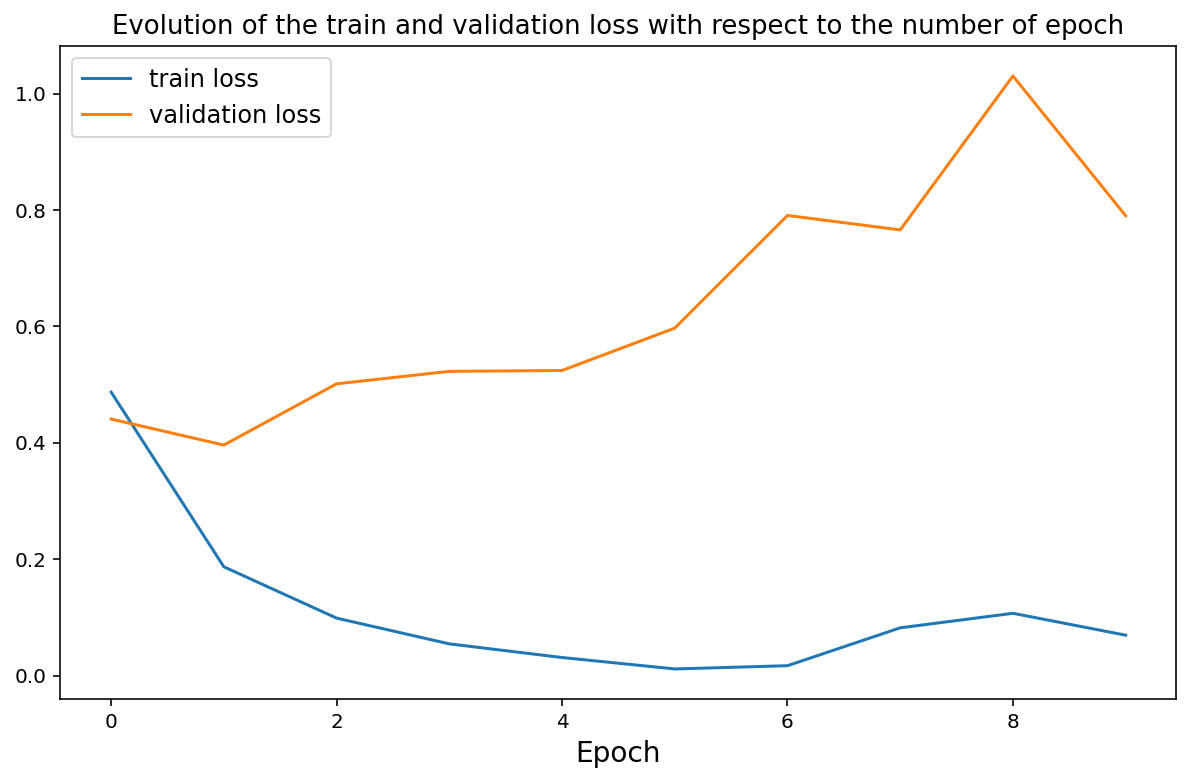

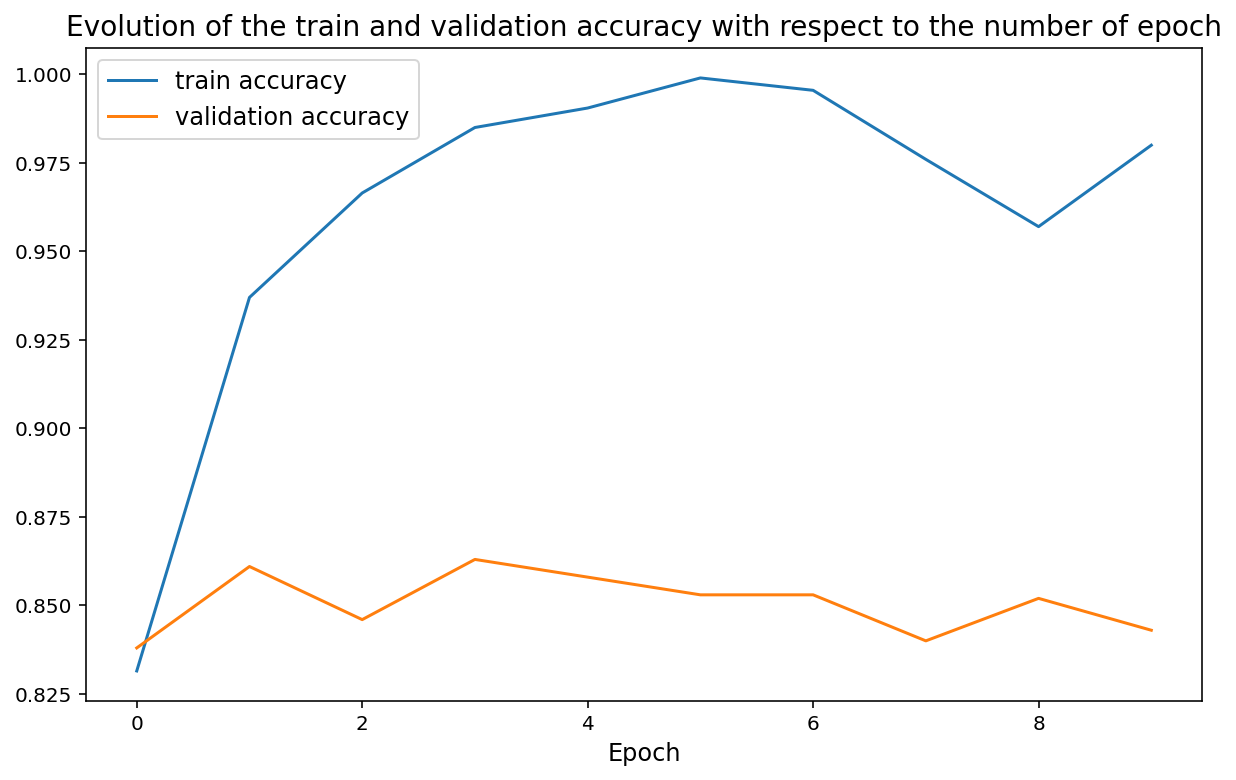

In [61]:
plt.figure(figsize=(10,6))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch', size=14)
plt.title('Evolution of the train and validation loss with respect to the number of epoch', size=13)

plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(10,6))

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch', size=12)
plt.title('Evolution of the train and validation accuracy with respect to the number of epoch', size=14)

plt.legend(fontsize=12)
plt.show()

The plot shows that there is a lot of overfitting too which this model, and it does not perform a lot better on the test set than the Random Forest model. However, it is faster to train

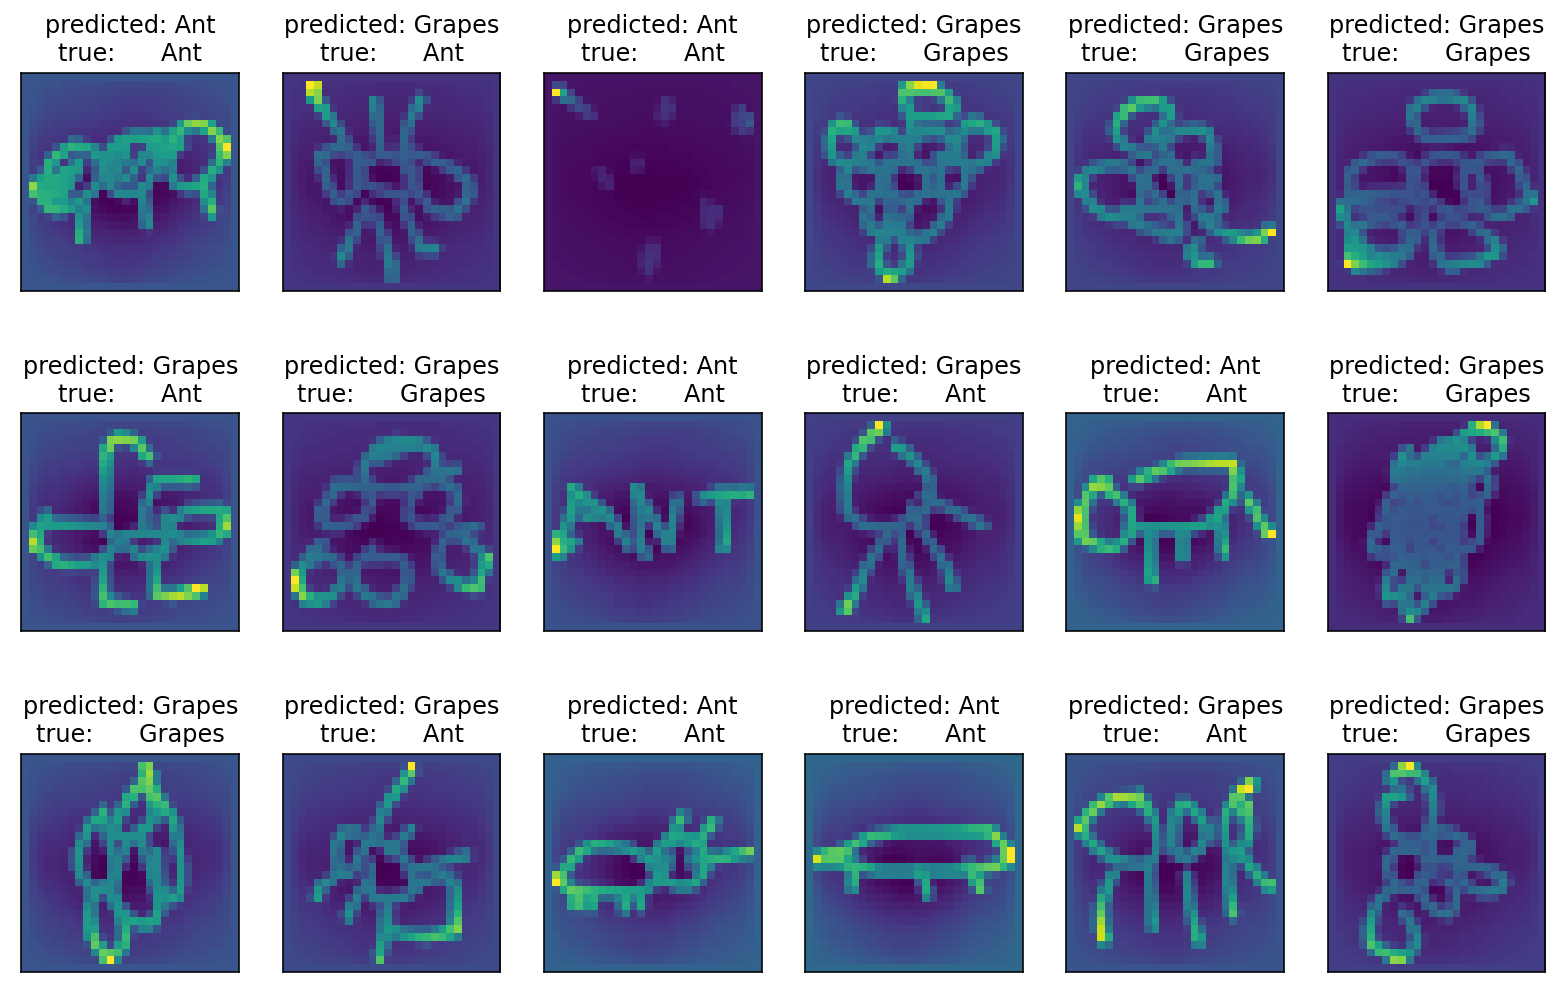

In [66]:
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    samples = np.random.randint(0, images.shape[0], size=n_row*n_col)
    for i,j in enumerate(samples):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[j].reshape(28,28,))
        plt.title(titles[j], size=12)
        plt.xticks(())
        plt.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

y_pred_rfc = rfc.predict(X_test)
prediction_titles = [title(y_pred_rfc[i], y_test[i], names)
                     for i in range(y_pred_rfc.shape[0])]

plot_gallery(X_test, prediction_titles)
pl.show()

In order to visualise the images and see how our Random Forest Classifier performs, we have plotted some of the images with theire true label and the predicted one. On average, our model makes 2 or 3 mistakes over the 24 images that we plot at a single time.

# Conclusions